In [1]:
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, Markdown, HTML # For rich output
import warnings

warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

current_dir = os.getcwd()
if os.path.basename(current_dir) == 'testing':
    project_root = os.path.abspath(os.path.join(current_dir, '..'))
    print(f"Determined project root from 'testing' CWD: {project_root}")
else:
    # Assuming CWD is the project root itself
    project_root = current_dir
    print(f"Assuming CWD is project root: {project_root}")

if project_root not in sys.path:
    sys.path.insert(0, project_root)
    print(f"Added project root to sys.path: {project_root}")
else:
    print(f"Project root already in sys.path: {project_root}")

from src.metrics import Pelt, STLFeatures, ACF_Features, CrossingPoints, LinearRegression

Determined project root from 'testing' CWD: c:\Users\Utilizador\Desktop\Faculdade\Projeto Investigação - Séries Temporais\EasyTest
Added project root to sys.path: c:\Users\Utilizador\Desktop\Faculdade\Projeto Investigação - Séries Temporais\EasyTest


Attempting to load data from: c:\Users\Utilizador\Desktop\Faculdade\Projeto Investigação - Séries Temporais\EasyTest\data\AirPassengers.csv
Successfully loaded AirPassengers data. Shape: (144,)


### Original AirPassengers Data

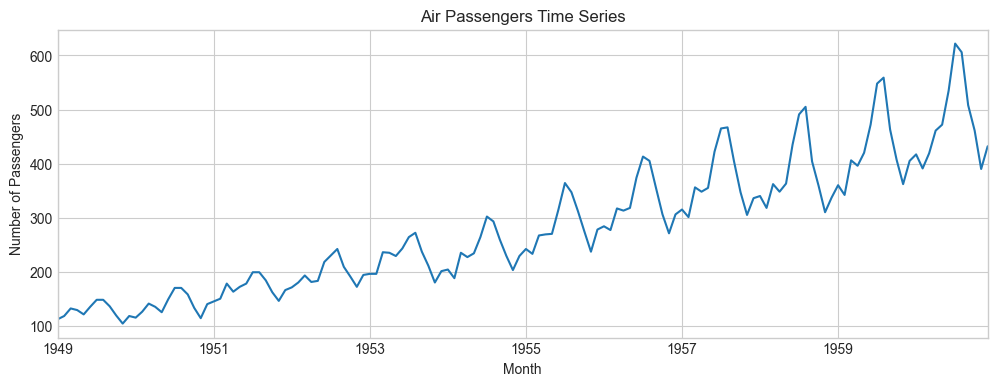

Series length (N): 144


In [3]:
# --- Plotting defaults ---
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 4)
plt.rcParams['figure.dpi'] = 100

# ## 1. Load AirPassengers Data

# --- Load Data ---
data_file_path = os.path.join(project_root, 'data', 'AirPassengers.csv')
print(f"Attempting to load data from: {data_file_path}")

df_air = pd.read_csv(
    data_file_path,
    parse_dates=['Month'],
    index_col='Month'
)

# RENAME column if it's different in your file
if '#Passengers' not in df_air.columns:
    if 'Passengers' in df_air.columns:
        df_air.rename(columns={'Passengers': '#Passengers'}, inplace=True)
        print("Renamed 'Passengers' column to '#Passengers'")
    else:
        # This will raise KeyError if the column isn't found
        raise KeyError("Could not find '#Passengers' column or 'Passengers'. Please check CSV.")

passenger_series_np = df_air['#Passengers'].to_numpy(dtype=float)
print(f"Successfully loaded AirPassengers data. Shape: {passenger_series_np.shape}")

# Plot the data
display(Markdown("### Original AirPassengers Data"))
df_air['#Passengers'].plot()
plt.title('Air Passengers Time Series')
plt.ylabel('Number of Passengers')
plt.show()

# Define series length for convenience
N = len(passenger_series_np)
print(f"Series length (N): {N}")

### Pelt - Test 1: Default Parameters (`model='l2', min_size=2, jump=5`)

Instantiated Pelt with defaults.
Using penalty = log(N) = 4.9698
Default Pelt found 27 change points.
Breakpoints (segment end points): [5, 10, 15, 20, 25, 30, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120, 125, 130, 135, 140, 144]


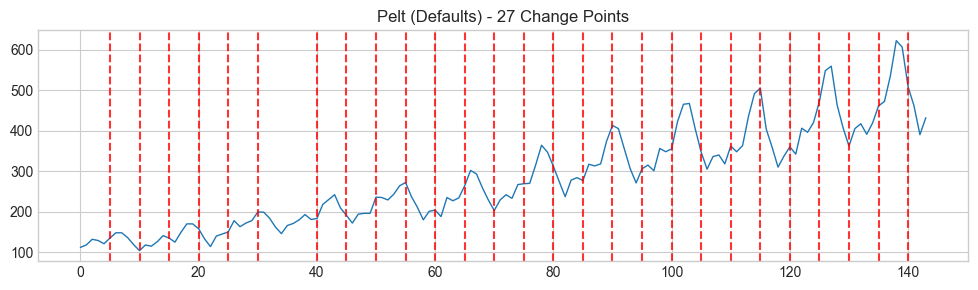

In [4]:
display(Markdown("### Pelt - Test 1: Default Parameters (`model='l2', min_size=2, jump=5`)"))

pelt_default = Pelt() # Defaults: model='l2', min_size=2, jump=5
pen_value_log = np.log(N) if N > 1 else 0
print(f"Instantiated Pelt with defaults.")
print(f"Using penalty = log(N) = {pen_value_log:.4f}")

pelt_default.fit(passenger_series_np)
bkps_default = pelt_default.predict(pen=pen_value_log)
# Adjust count based on how predict structures output (assuming it includes N)
n_changes = len(bkps_default) -1 if bkps_default and bkps_default[-1] == N else len(bkps_default)
print(f"Default Pelt found {n_changes} change points.")
print(f"Breakpoints (segment end points): {bkps_default}")

# Plot results
fig, ax = plt.subplots(figsize=(12, 3))
ax.plot(passenger_series_np, label="Data", linewidth=1)
ax.set_title(f"Pelt (Defaults) - {n_changes} Change Points")
plot_bkps = [b for b in bkps_default if b < N] # Don't plot line at the very end
for b in plot_bkps:
     ax.axvline(b, color='r', linestyle='--', lw=1.5, alpha=0.8)
plt.show()

### Pelt - Test 2: Different Model (`model='l1', min_size=3`)

Instantiated Pelt with: model='l1', min_size=3, jump=5
Using penalty=4.9698
L1 Pelt found 26 change points.
Breakpoints: [5, 10, 15, 20, 25, 30, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 120, 125, 130, 135, 140, 144]


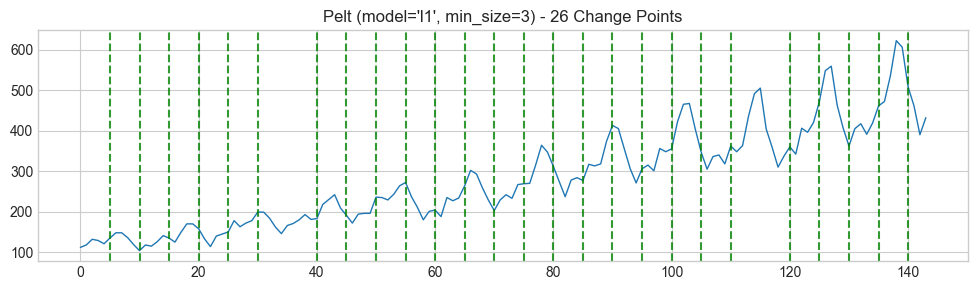

In [ ]:
display(Markdown("### Pelt - Test 2: Different Model (`model='l1', min_size=3`)"))

pelt_l1 = Pelt(model='l1', min_size=3) # Example: L1 cost, slightly larger min_size
print(f"Instantiated Pelt with: model='l1', min_size=3, jump=5")
print(f"Using penalty={pen_value_log:.4f}")

pelt_l1.fit(passenger_series_np)
bkps_l1 = pelt_l1.predict(pen=pen_value_log)
n_changes_l1 = len(bkps_l1) -1 if bkps_l1 and bkps_l1[-1] == N else len(bkps_l1)
print(f"L1 Pelt found {n_changes_l1} change points.")
print(f"Breakpoints: {bkps_l1}")

# Plot results
fig, ax = plt.subplots(figsize=(12, 3))
ax.plot(passenger_series_np, label="Data", linewidth=1)
ax.set_title(f"Pelt (model='l1', min_size=3) - {n_changes_l1} Change Points")
plot_bkps_l1 = [b for b in bkps_l1 if b < N]
for b in plot_bkps_l1: ax.axvline(b, color='g', linestyle='--', lw=1.5, alpha=0.8)
plt.show()

In [ ]:
display(Markdown("### Pelt - Test 3: Higher Jump (`jump=10`)"))

pelt_jump = Pelt(model='l2', jump=10) # Example: Default model, larger jump
print(f"Instantiated Pelt with: model='l2', min_size=2, jump=10")
print(f"Using penalty={pen_value_log:.4f}")

pelt_jump.fit(passenger_series_np)
bkps_jump = pelt_jump.predict(pen=pen_value_log)
n_changes_jump = len(bkps_jump) -1 if bkps_jump and bkps_jump[-1] == N else len(bkps_jump)
print(f"Jump=10 Pelt found {n_changes_jump} change points.")
print(f"Breakpoints: {bkps_jump}")
# Optional plot here if desired

### Pelt - Test 3: Higher Jump (`jump=10`)

Instantiated Pelt with: model='l2', min_size=2, jump=10
Using penalty=4.9698
Jump=10 Pelt found 14 change points.
Breakpoints: [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 144]


In [ ]:
display(Markdown("### STLFeatures - Test 1: `freq=12`, Default `seasonal` (7), `robust=False`"))
stl_default = STLFeatures(freq=12) # AirPassengers is monthly
print(f"Instantiated with: freq={stl_default.freq}, seasonal={stl_default.seasonal}, robust={stl_default.robust}")

features_default = stl_default.get_features(passenger_series_np)
print("\nFeatures calculated (Defaults):")
for k, v in features_default.items(): print(f"  {k}: {v:.4f}" if isinstance(v, float) else f"  {k}: {v}")

### STLFeatures - Test 1: `freq=12`, Default `seasonal` (7), `robust=False`

Instantiated with: freq=12, seasonal=7, robust=False

Features calculated (Defaults):
  nperiods: 1
  seasonal_period: 12
  trend: 0.9980
  spike: 0.0974
  linearity: 1.6558
  curvature: -0.0070
  e_acf1: 0.1751
  e_acf10: -0.0257
  seasonal_strength: 0.9867
  peak: 7
  trough: 11


In [ ]:
display(Markdown("### STLFeatures - Test 2: Longer `seasonal` (13)"))
stl_longseas = STLFeatures(freq=12, seasonal=13) # Must be odd
print(f"\nInstantiated with: freq={stl_longseas.freq}, seasonal={stl_longseas.seasonal}, robust={stl_longseas.robust}")

features_longseas = stl_longseas.get_features(passenger_series_np)
print("\nFeatures calculated (seasonal=13):")
for k, v in features_longseas.items(): print(f"  {k}: {v:.4f}" if isinstance(v, float) else f"  {k}: {v}")
# Compare trend strength:
trend_diff = features_longseas.get('trend', np.nan) - features_default.get('trend', np.nan)
print(f"  Trend Strength Change vs Default: {trend_diff:.4f}")

### STLFeatures - Test 2: Longer `seasonal` (13)


Instantiated with: freq=12, seasonal=13, robust=False

Features calculated (seasonal=13):
  nperiods: 1
  seasonal_period: 12
  trend: 0.9972
  spike: 0.1628
  linearity: 1.6675
  curvature: -0.0069
  e_acf1: 0.0916
  e_acf10: -0.3966
  seasonal_strength: 0.9815
  peak: 7
  trough: 11
  Trend Strength Change vs Default: -0.0008


In [ ]:
display(Markdown("### STLFeatures - Test 3: `robust=True`"))
stl_robust = STLFeatures(freq=12, seasonal=7, robust=True)
print(f"\nInstantiated with: freq={stl_robust.freq}, seasonal={stl_robust.seasonal}, robust={stl_robust.robust}")

features_robust = stl_robust.get_features(passenger_series_np)
print("\nFeatures calculated (robust=True):")
for k, v in features_robust.items(): print(f"  {k}: {v:.4f}" if isinstance(v, float) else f"  {k}: {v}")
# Compare trend strength:
trend_diff_robust = features_robust.get('trend', np.nan) - features_default.get('trend', np.nan)
print(f"  Trend Strength Change vs Default: {trend_diff_robust:.4f}")


### STLFeatures - Test 3: `robust=True`


Instantiated with: freq=12, seasonal=7, robust=True

Features calculated (robust=True):
  nperiods: 1
  seasonal_period: 12
  trend: 0.9962
  spike: 0.8442
  linearity: 1.6252
  curvature: -0.0073
  e_acf1: 0.2483
  e_acf10: 0.0890
  seasonal_strength: 0.9753
  peak: 8
  trough: 11
  Trend Strength Change vs Default: -0.0018


In [17]:
display(Markdown("### ACF_Features - Test 1: Default `nlags=10`"))
acf_default = ACF_Features() # Default nlags=10
print(f"Instantiated with: nlags={acf_default.nlags}")

features_default_acf = acf_default.get_features(passenger_series_np)
print("ACF Features (Defaults):")
for k, v in features_default_acf.items(): print(f"  {k}: {v:.4f}")


### ACF_Features - Test 1: Default `nlags=10`

Instantiated with: nlags=10
ACF Features (Defaults):
  x_acf1: 0.9480
  x_acf10: 7.4706


In [18]:
display(Markdown("### ACF_Features - Test 2: `nlags=20`"))
acf_20 = ACF_Features(nlags=20)
print(f"\nInstantiated with: nlags={acf_20.nlags}")

features_20_acf = acf_20.get_features(passenger_series_np)
print("ACF Features (nlags=20):")
# The returned dict keys are still x_acf1, x_acf10 (sum up to 10) by implementation.
for k, v in features_20_acf.items(): print(f"  {k}: {v:.4f}")
# Compare: Values should be identical unless series is very short.
if features_default_acf and features_20_acf:
     print(f"  ACF1 Change vs Default: {features_20_acf.get('x_acf1', np.nan) - features_default_acf.get('x_acf1', np.nan):.4f}")
     print(f"  ACF10 Change vs Default: {features_20_acf.get('x_acf10', np.nan) - features_default_acf.get('x_acf10', np.nan):.4f}")

### ACF_Features - Test 2: `nlags=20`


Instantiated with: nlags=20
ACF Features (nlags=20):
  x_acf1: 0.9480
  x_acf10: 7.4706
  ACF1 Change vs Default: 0.0000
  ACF10 Change vs Default: 0.0000


In [19]:
display(Markdown("### CrossingPoints - Test 1: Default"))
cp_tester = CrossingPoints() # Takes no arguments now
print("Instantiated CrossingPoints.")

features_cp = cp_tester.get_features(passenger_series_np)
print("Crossing Points Features:")
for k, v in features_cp.items(): print(f"  {k}: {v}") # Integer result

### CrossingPoints - Test 1: Default

Instantiated CrossingPoints.
Crossing Points Features:
  crossing_points: 7.0


### LinearRegression - Test 1: Default

Instantiated LinearRegression.

Linear Regression Results:
  Intercept: 90.3100
  Slope (coef_): 2.6572
  R-squared (score): 0.8536


#### Linear Regression Fit Plot

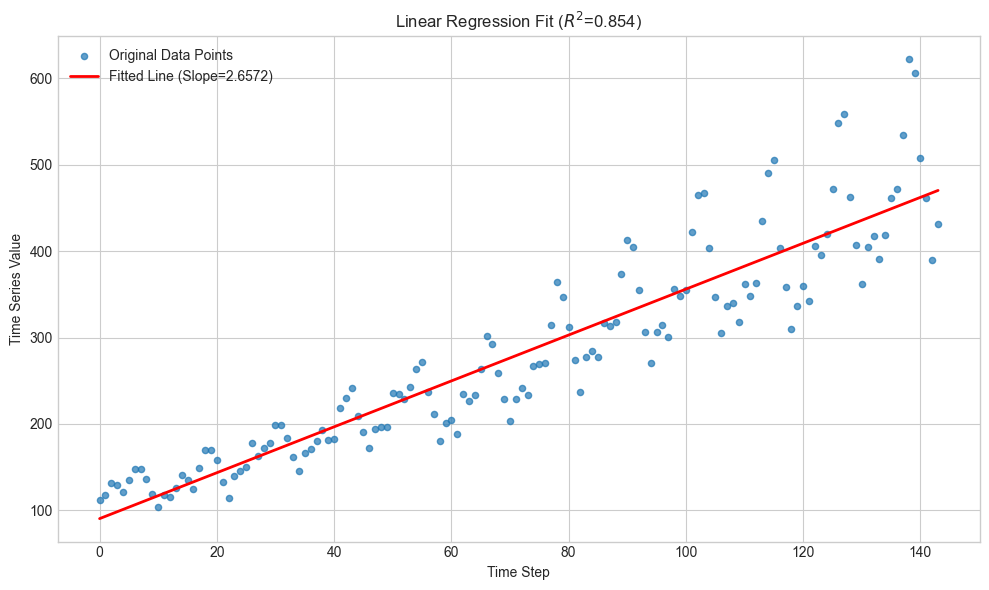

In [20]:
display(Markdown("### LinearRegression - Test 1: Default"))
lr_tester = LinearRegression() # Takes no arguments
print("Instantiated LinearRegression.")

lr_tester.fit(passenger_series_np)
print("\nLinear Regression Results:")
print(f"  Intercept: {lr_tester.intercept_:.4f}")
print(f"  Slope (coef_): {lr_tester.coef_:.4f}")
print(f"  R-squared (score): {lr_tester.score():.4f}")

# Show plot
display(Markdown("#### Linear Regression Fit Plot"))
lr_tester.plot_fit()